In [1]:
import sys
# import estimators
%matplotlib widget
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

In [2]:
import lightkurve as lk

search_result = lk.search_lightcurve("TOI-540", author="SPOC", exptime=120)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,200322593,0.0
1,TESS Sector 05,2018,SPOC,120,200322593,0.0
2,TESS Sector 06,2018,SPOC,120,200322593,0.0
3,TESS Sector 31,2020,SPOC,120,200322593,0.0
4,TESS Sector 32,2020,SPOC,120,200322593,0.0


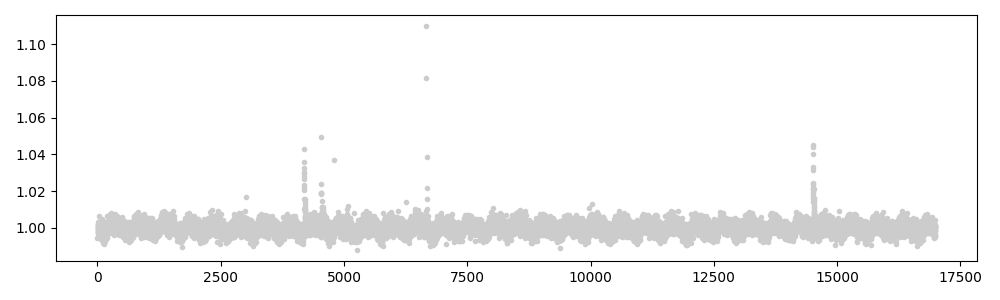

In [12]:
i = 1
sector = search_result[i].mission[0]

# data
klc = [search_result[i].download() for i in [i]] #range(2)]
#klc = search_result.download_all()
times = [k.time.to_value('mjd') for k in klc]
fluxes = [k.pdcsap_flux.to_value().filled(np.nan) for k in klc]
errors = [k.flux_err.to_value().filled(np.nan) for k in klc]
masks = [np.isnan(f) | np.isnan(e) | np.isnan(t) for f, e, t in zip(fluxes, errors, times)]
times = [t[~m] for t, m in zip(times, masks)]

# masking
time = np.hstack(times)
original_flux = np.hstack([f[~m] for f, m in zip(fluxes, masks)])
original_error = np.hstack([e[~m] for e, m in zip(errors, masks)])

# norm
flux_median = np.median(original_flux)
flux =  original_flux / flux_median
error = original_error / flux_median

plt.figure(None, (10, 3))
plt.plot(flux, ".", c="0.8")
plt.tight_layout()

# Design matrix

In [6]:
X = time**np.arange(0, 3)[:, None]
X[1::] -= X[1::].mean(1)[:, None]
X[1::] /= X[1::].std(1)[:, None]

# GP

In [7]:
from tinygp import kernels, GaussianProcess
import yaml

params = yaml.full_load(open("../data/gp.yaml", "r"))

kernel = kernels.quasisep.SHO(
    omega=params["omega"], 
    quality=params["quality"], 
    sigma=params["sigma"]
) 
    
gp = GaussianProcess(kernel, time, diag=params["jitter"]**2, mean=1.)

In [8]:
from nuance import Nuance
from tinygp import kernels, GaussianProcess

nu = Nuance(time, flux, gp, X)

t0s = time.copy()
Ds = np.linspace(0.01, 0.1, 10)
result = nu.linear_search(t0s, Ds)

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/14569 [00:00<?, ?it/s]

In [10]:
searches = []
search = result.copy()
periods = np.linspace(.9, 5., 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

SNR < 5


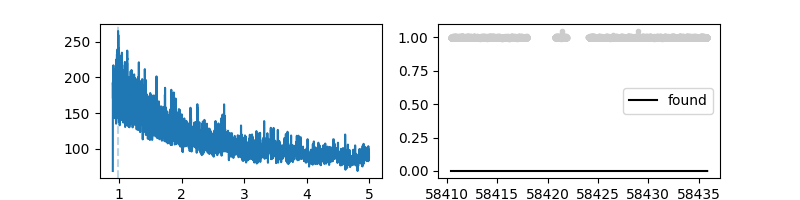

In [11]:
search = nu.periodic_search(search, periods)

t0, D, P = search.best
snr = nu.snr(t0, D, P)
    
plt.figure(None, (8, 2))
plt.subplot(1, 2, 1)
plt.axvline(P, ls="--", c="C0", alpha=0.3)
plt.plot(*search.periodogram())

mean, astro, noise = nu.models(t0, D, P)
astro = astro.__array__()
noise = noise.__array__()
if len(searches)>0:
    _t0s, _Ds, _Ps = np.array([s.best for s in searches]).T
    m = nu.mask(_t0s, _Ds, _Ps)
else:
    m = np.ones_like(t0s).astype(bool)

plt.subplot(1, 2, 2)
plt.plot(time[m], flux[m], ".", c="0.8")
plt.plot(time[m], astro[m], c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

if snr > 5.:
    print(f"""t0: {t0:.2f}
duration: {D:.2f}
period: {P:.3f}
depth: {nu.depth(t0, D, P)[0]:1.2e}
SNR: {snr:.2f}""")
else:
    print("SNR < 5")

searches.append(search.copy())
search = search.mask(t0, D, P)